# pyTorch Convolutional Neural Networks (CNNs)

<div style="padding: 5px; border: 5px solid #a10000ff;">

**Hinweis:** In den Codezellen sind jeweils einige Codeteile nicht programmiert. Diesen Code müssen Sie ergänzen. Die jeweiligen Stellen sind mit einem Kommentar und dem Keyword **TODO** vermerkt und z.T. Stellen mit ... markiert.

Ausserdem gibt es einige assert Statements. Diese geben einen Fehler aus, sollte etwas bei Ihrer Programmierung nicht korrekt sein.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os


## Hintergrundinformationen zu CNNs

Convolutional Neural Networks (CNNs) sind eine spezielle Art von künstlichen neuronalen Netzwerken, die besonders gut für die Verarbeitung von Bilddaten geeignet sind. Sie bestehen wie andere neuronale Netze aus mehreren Schichten, darunter Convolutional Layers, Pooling Layers und Fully Connected Layers.

- **Convolutional Layers**: Diese Schichten verwenden Filter (auch als Kernel bezeichnet), um Features im Eingabebild zu erkennen. Dies ermöglicht es dem Netzwerk, Muster wie Kanten, Ecken und Texturen zu erkennen.
- **Pooling Layers**: Diese Schichten reduzieren die räumlichen Dimensionen der Daten, indem sie Informationen zusammenfassen. Dies hilft, die Anzahl der Parameter zu reduzieren und die Rechenleistung zu verbessern.
- **Fully Connected Layers**: Diese Schichten verbinden alle Neuronen der vorherigen Schicht mit allen Neuronen der nächsten Schicht. Sie werden oft am Ende eines CNNs verwendet, um die erkannten Features in eine Klassifikation oder Regression umzuwandeln.

In diesem Notebook werden wir die Grundlagen von CNNs in PyTorch kennenlernen und ein einfaches CNN für die Bildklassifikation implementieren.

### Torch vorbereiten

In [2]:
# Wir prüfen ob eine Hardwarebeschleunigung möglich ist und verwenden diese, wenn sie verfügbar ist
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit
print(f"Using {device} device")

Using cpu device


## MNIST Dataset vorbereiten, laden und visualisieren

Wir nutzen für dieses Notebook den MNIST-Datensatz, der handgeschriebene Ziffern enthält. Das Modell muss lernen, diese Ziffern korrekt zu klassifizieren.

Wir werden diesen Datensatz laden, vorbereiten und einige Beispiele visualisieren.

In [3]:
# Mnist Dataset laden
mnist_train = torchvision.datasets.MNIST(root='datasets', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='datasets', train=False, download=True)

### Daten validieren

Damit wir die Daten benutzen können, müssen alle Daten gleich formiert sein, heisst alle Bilder müssen die gleiche Grösse haben, die Pixelwerte müssen in einem bestimmten Bereich liegen, etc. 

In diesem Abschnitt prüfen wir, ob es verschiedene Bildgrössen gibt, ob alle Pixelwerte von 0 bis 255 reichen und zeigen ein Beispiel eines Bildes an.

In [4]:
# Die Anzahl Trainings- und Testdaten anzeigen
print(f"Anzahl Trainingsbilder: {len(mnist_train)}")
print(f"Anzahl Testbilder: {len(mnist_test)}")


# Prüfen, dass alle Bilder die gleiche Grösse haben
image_sizes = [image.size for image, _ in mnist_train]
print(f"Einzigartige Bildgrössen: {set(image_sizes)}")

Anzahl Trainingsbilder: 60000
Anzahl Testbilder: 10000
Einzigartige Bildgrössen: {(28, 28)}


#### Beispiel Data Sample anzeigen

Label: 5


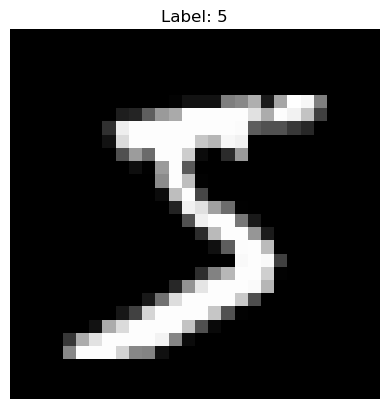

In [5]:
# Ein Beispielbild aus dem Trainingsdatensatz anzeigen
image, label = mnist_train[0]
print(f"Label: {label}")
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

#### Prüfen der Pixelwerte

In [6]:
# Prüfen, dass die Pixelwerte im Bereich von 0 bis 255 liegen
pixel_values = [image.getdata() for image, _ in mnist_train]
pixel_values_flat = [pixel for sublist in pixel_values for pixel in sublist]
print(f"Min Pixelwert: {min(pixel_values_flat)}")
print(f"Max Pixelwert: {max(pixel_values_flat)}")

# Labels prüfen
labels = [label for _, label in mnist_train]
print(f"Einzigartige Labels: {set(labels)}")

Min Pixelwert: 0
Max Pixelwert: 255
Einzigartige Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


#### Aufgabe 1

1. Was bedeutet es, wenn die Bilder unterschiedliche Grössen haben? Was könnte das für Probleme verursachen?

2. Wenn wir das Modell auf neue Daten anwenden möchten, was müssen wir sicherstellen, damit das Modell die neuen Daten korrekt verarbeiten kann?



### Data Loader erstellen

In diesem Abschnitt erstellen wir einen Data Loader, um die Daten in Batches zu laden und für das Training vorzubereiten. 
Die Daten sind in Trainings- und Testsets aufgeteilt.

In [7]:
# Damit wir die Bilder in einem CNN verwenden können, müssen wir die Bilder in Tensoren umwandeln. Wir erstellen deshalb eine neue Version des MNIST-Datensatzes, bei der die Bilder bereits in Tensoren umgewandelt wurden.
# Für die Umwandlung verwenden wir die ToTensor-Transformation von torchvision, welche die Bilder in Tensoren umwandelt und die Pixelwerte normalisiert (0-255 -> 0-1). 
# Die Normalisierung ist wichtig, damit das Training stabiler und schneller lernt.

transform = torchvision.transforms.ToTensor()

mnist_transformed_train = torchvision.datasets.MNIST(root='datasets', train=True, download=True, transform=transform)
mnist_transformed_test = torchvision.datasets.MNIST(root='datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_transformed_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_transformed_test, batch_size=64, shuffle=False)

## Neural Network Architektur definieren

In diesem Abschnitt definieren wir die Architektur unseres Convolutional Neural Networks. 

Wir werden mehrere Convolutional Layers, Pooling Layers und Fully Connected Layers verwenden, um ein Modell zu erstellen, das in der Lage ist, die Bilder im MNIST-Datensatz zu klassifizieren.

### Berechnung der Dimensionen der verschiedenen Layers

In pyTorch müssen wir die Dimensionen der Daten durch die verschiedenen Schichten unseres Netzwerks verfolgen, um die Dimensionen der einzelnen Layers zu konfigurieren.

In diesem Abschnitt berechnen wir die Dimensionen der Daten nach jeder Schicht in unserem CNN.

#### Aufgabe 2

Wir möchten folgende Architektur für unser CNN verwenden:
```
Input (28x28) --> Conv1 (7x7, 12 Filter, Stride 1, Padding 0) --> Pool1 (2x2, Stride 2) --> Conv2 (5x5, 16 Filter, Stride 1, Padding 2) --> Pool2 (2x2, Stride 2) --> Fully Connected Layer
```




1. Berechnen Sie die Bildgrösse nach dem ersten Convolutional Layer:

> Hinweis: Überlegen Sie sich wie sich die Bildgrösse mit dem verwendeten Kernel, Padding und Stride verändert.

> Bildgrösse = 28x28, Kernel Size = 7 , Padding = 0, Stride = 1
> Auf jeder Seite des Bildes vermindert der Kernel die Bildgrösse um 3 Pixel. Da wir kein Padding verwenden und der Stride 1 ist, vermindert sich die Bildgrösse um 6 Pixel (3 Pixel auf jeder Seite).
> Output Size = 22x22

2. Berechnen Sie die Bildgrösse nach dem ersten Pooling Layer:
> Pooling Size = 2x2, Stride = 2 --> Die Pooling-Schicht reduziert die Bildgrösse um die Hälfte, da sie 2x2 Bereiche zusammenfasst und der Stride 2 ist.
> Output Size = 11x11

3. Berechnen Sie die Bildgrösse nach dem zweiten Convolutional Layer:
> Kernel Size = 5, Padding = 2, Stride = 1
> Da wir ein Padding von 2 verwenden und die Kernel-Grösse 5 ist, bleibt die Bildgrösse gleich. --> Output Size = 11x11

4. Berechnen Sie die Bildgrösse nach dem zweiten Pooling Layer:
> Pooling Size = 2x2, Stride = 2 --> Die Pooling-Schicht reduziert die Bildgrösse um die Hälfte, da sie 2x2 Bereiche zusammenfasst und der Stride 2 ist.
> Output Size = 5x5

5. Wie viele Neuronen muss der Fully Connected Layer haben, um die Daten korrekt zu verarbeiten? (Tipp: wir müssen die Anzahl der Kanäle und die Bildgrösse nach dem letzten Pooling Layer berücksichtigen)

> Nach dem zweiten Pooling haben wir 16 Kanäle und die Bildgrösse ist 5x5. Daher müssen wir 16 * 5 * 5 = 400 Neuronen im Fully Connected Layer haben, um alle Informationen aus den vorherigen Schichten zu verarbeiten.


In [8]:
# TODO erstellen Sie mit torch.nn.sequential ein Convolutional Neural Network mit folgenden Schichten:
# - Convolutional Layer mit einem Eingabe-Kanal, 12 Ausgabekanälen, einem Kernel von 7x7, einem Stride von 1 und einem Padding von 0
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - RELU Aktivierungsfunktion
# - Convolutional Layer mit 12 Eingabekanälen, 16 Ausgabekanälen, einem Kernel von 5x5, einem Stride von 1 und einem Padding von 2
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - RELU Aktivierungsfunktion
# - Flatten Layer, um die Daten für die Fully Connected Layer vorzubereiten
# - Fully Connected Layer mit der Anzahl Eingabeneuronen die Sie oben berechnet haben und 10 Ausgabeneuronen.

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16*5*5, out_features=10),
)

## Netzwerk trainieren und evaluieren
In diesem Abschnitt trainieren wir unser CNN mit dem MNIST-Datensatz und evaluieren die Leistung des Modells auf dem Testset. Wir werden die Trainings- und Testgenauigkeit berechnen und die Ergebnisse visualisieren.

### Netzwerk trainieren

Vervollständigen Sie den Trainingsloop, um das CNN zu trainieren.

Epoch 0: Train Loss = 0.22039, Test Loss = 0.33384
Epoch 1: Train Loss = 0.06171, Test Loss = 0.18738
Epoch 2: Train Loss = 0.09896, Test Loss = 0.12267
Epoch 3: Train Loss = 0.05796, Test Loss = 0.10420
Epoch 4: Train Loss = 0.09065, Test Loss = 0.09215
Epoch 5: Train Loss = 0.14521, Test Loss = 0.07630
Epoch 6: Train Loss = 0.01649, Test Loss = 0.06982
Epoch 7: Train Loss = 0.13677, Test Loss = 0.06238
Epoch 8: Train Loss = 0.01998, Test Loss = 0.06175
Epoch 9: Train Loss = 0.00387, Test Loss = 0.05657


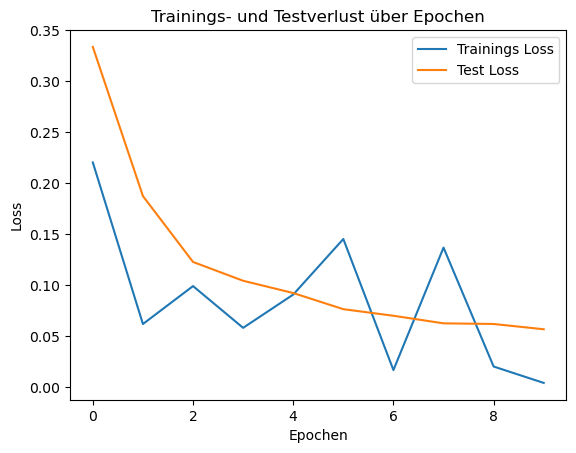

In [9]:
# Hyperparameter definieren
max_num_epochs = 10
learning_rate = 0.001
momentum = 0.9

# Optimizer und die Loss-Funktion definieren
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
loss = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []

# Das Modell muss noch auf die Hardware verschoben werden.
model.to(device)

for epoch in range(max_num_epochs):
    for batch in train_loader:
        images, labels = batch

        # Wir verschieben die Bilder und Labels auf die gleiche Hardware wie das Modell (CPU oder GPU)
        images, labels = images.to(device), labels.to(device)

        # TODO vervollständigen Sie hier die nötigen Schritte, um das Modell zu trainieren
        optimizer.zero_grad()
        outputs = model(images)

        train_loss = loss(outputs, labels)
        train_loss.backward()
        optimizer.step()

    train_losses.append(train_loss.item())

    with torch.no_grad():
        test_loss = 0
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            test_loss += loss(outputs, labels).item()
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch}: Train Loss = {train_loss.item():.5f}, Test Loss = {test_loss / len(test_loader):.5f}")

# Speichere das trainierte Modell
torch.save(model.state_dict(), "mnist_cnn.pth")

# Test und Trainingsverluste visualisieren
plt.plot(train_losses, label='Trainings Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.title('Trainings- und Testverlust über Epochen')
plt.legend()
plt.show()


In [10]:
# Testen ob das File für das Modell existiert und das Modell geladen werden kann
if os.path.exists("mnist_cnn.pth"):
    model.load_state_dict(torch.load("mnist_cnn.pth"))
    print("Modell erfolgreich geladen!")


Modell erfolgreich geladen!


In [11]:
# Berechne die Accuracy des Modells auf dem Testset
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.33%
